In [1]:
%matplotlib inline

In [2]:
import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

In [3]:
DEVICE_ID = 0
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

In [4]:
### Для запуска без GPU раскомментировать и закоментировать код выше
# DEVICE = torch.device('cpu')

In [4]:
np.random.seed(100500)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
                        
        data = np.load(input_path)
        if is_train: 
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [6]:
#Надо поменять пути на свои до файлов с kaggle
DATA_PATH  = '/home/a.murashev/2018_2/04/kaggle04_files/'
train_path = 'homework_4.train.npy'
test_path  = 'homework_4_no_classes.test.npy'

In [6]:
DATA_PATH  = '/media/denis/b80fa2a5-44af-425c-bdb4-8d3f9d0f5605/denis/'
train_path = 'homework_4.train.npy'
test_path  = 'homework_4_no_classes.test.npy'

In [7]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [8]:
np_mean.shape

(3,)

In [9]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [94]:
#для монитроинга переобучиня с валид датасетом
dataset_train_norm = CifarDataset(DATA_PATH + train_path, transform=cifar_transform_norm)
train_size = int(0.8 * len(dataset_train_norm))
test_size = len(dataset_train_norm) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_train_norm, [train_size, test_size])

dataloader_train_norm = DataLoader(train_dataset, batch_size=512,
                        shuffle=True, num_workers=5)
dataloader_valid_norm = DataLoader(test_dataset, batch_size=512,
                        shuffle=True, num_workers=5)

dataset_test_norm = CifarDataset(DATA_PATH + test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=512,
                        shuffle=False, num_workers=1)


def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  a_epochs=80,
                  a_batch_size=512,
                  a_lr=0.1):
    
    train_acc = []
    valid_acc = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9)

    
    for epoch in range(a_epochs):  # loop over the dataset multiple times
        if epoch == 60:#22
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.001, momentum=0.9) 
        elif epoch == 100:#40
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/100, weight_decay=0.001, momentum=0.9) 
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_accuracy += accuracy_score(labels, prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_valid_norm:
            epoch_iters += 1
            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)
            outputs = net(inputs)
            epoch_accuracy += accuracy_score(labels, prediction2classes(outputs))
        epoch_accuracy /= epoch_iters
        valid_acc.append(epoch_accuracy)
        print("Epoch ", epoch, loss, round(train_acc[-1], 4), round(valid_acc[-1], 4))

    print('Finished Training')
    
    plt.plot(train_acc, label='Train')
    plt.plot(valid_acc, label='Valid')
    plt.legend()
    plt.grid()

In [16]:
dataset_train_norm = CifarDataset(DATA_PATH + train_path, transform=cifar_transform_norm)
dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
                        shuffle=True, num_workers=6)

dataset_test_norm = CifarDataset(DATA_PATH + test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128,
                        shuffle=False, num_workers=1)


def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  a_epochs=80, #164
                  a_batch_size=128,
                  a_lr=0.1):
    
    train_acc = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9)

    
    for epoch in range(a_epochs):  # loop over the dataset multiple times
        if epoch == 60: 
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.0001, momentum=0.9) 
        elif epoch == 100:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/100, weight_decay=0.0001, momentum=0.9) 
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_accuracy += accuracy_score(labels, prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        
        print("Epoch ", epoch, round(train_acc[-1], 4))

    print('Finished Training')
    
    plt.plot(train_acc, label='Train')
    plt.legend()
    plt.grid()

In [11]:
class StupidDenseNet(nn.Module):
    
    def __init__(self):
        super(StupidDenseNet, self).__init__()
        
        #Один из способов задать сеть - это задать последовательность слоев через Sequential
        self.classifier = nn.Sequential()
        self.classifier.add_module('lin1', nn.Linear(3*32*32, 500))
        self.classifier.add_module('sig1', torch.nn.Sigmoid())
        self.classifier.add_module('lin2', nn.Linear(3*32*32, 500))
        self.classifier.add_module('sig2', torch.nn.Sigmoid())
        self.classifier.add_module('lin3', nn.Linear(3*32*32, 500))
        self.classifier.add_module('sig3', torch.nn.Sigmoid())
        
    def forward(self, x):
        x = self.classifier(x)
        return x

In [67]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()

        ### Другой способ задания сети - это описать слои и в forward их применять явно
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #Увеличиваем кол-во выходных слоев с 84 - до 84*2 - потому что классов 100
        self.fc2 = nn.Linear(120, 84*2)
        self.fc3 = nn.Linear(84*2, 100)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [11]:
DOWNSAMPLE_COEF = 2

def conv3x3(a_in_planes, a_out_planes, a_stride=1):
    """
    Основной строительный блок конволюций для ResNet
    Включает в себя padding=1 - чтобы размерность сохранялась после его применения
    """
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=3, padding=1, bias=False)
def conv1x1(a_in_planes, a_out_planes, a_stride=1):
    """
    Основной строительный блок конволюций для ResNet
    Включает в себя padding=1 - чтобы размерность сохранялась после его применения
    """
    
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=1, padding=0, bias=False)

def x_downsample(a_in_channels):
     return nn.Conv2d(a_in_channels, 
               a_in_channels*DOWNSAMPLE_COEF,
               kernel_size=1,
               stride=2,
               bias=False)

In [12]:
class CifarResidualBlock(nn.Module):
    def __init__(self, in_channels, stride=1, make_downsample=False, use_skip_connection=True):
        super(CifarResidualBlock, self).__init__()
        
        if make_downsample: 
            coef = DOWNSAMPLE_COEF
        else: coef = 1  
        self.use_skip_connection=use_skip_connection
        self.make_downsample=make_downsample

        self.conv1 = conv3x3(in_channels, in_channels*coef, a_stride=1*coef)
        
        self.bn1 = nn.BatchNorm2d(in_channels*coef)

        self.relu = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(in_channels*coef, in_channels*coef, stride)

        self.bn2 = nn.BatchNorm2d(in_channels*coef)

        self.downsample = x_downsample(in_channels)

        #self.stride = stride
            
    def forward(self, x):
        #if  self.make_downsample is True:
            #residual = self.downsample(x)
            #x=self.downsample(x)
            #pass
       # else:
            #residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        #out = self.relu(out)
        if self.use_skip_connection is True:
            if  self.make_downsample is True:
                residual = self.downsample(x)
            else:
                residual=x
            out += residual
        out = self.relu(out)
        return out

In [14]:
class CifarResNet(nn.Module):
    
    def __init__(self):
        super(CifarResNet, self).__init__()#TODO нужно добавить блоков resnet и других слоев при необходимости
        
        self.features = nn.Sequential()
                #TODO нужно добавить блоков resnet и других слоев при необходимости
        #self.features = nn.Sequential(OrderedDict([
         #   ('conv0', nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)),
          #  ('norm0', nn.BatchNorm2d(num_init_features)),
           # ('relu0', nn.ReLU(inplace=True)),
            #('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
#]))
        
        self.features.add_module('conv7x7',nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=5, bias=False))
        self.features.add_module('bn',nn.BatchNorm2d(64))
        self.features.add_module('relu1',nn.ReLU(inplace=True))
        #self.features.add_module('maxpool',nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        self.features.add_module('res_block1', CifarResidualBlock(64))
        self.features.add_module('res_block2', CifarResidualBlock(64))
        self.features.add_module('res_block3', CifarResidualBlock(64))
        self.features.add_module('res_block4', CifarResidualBlock(64, make_downsample=True, use_skip_connection=True))
        self.features.add_module('res_block5', CifarResidualBlock(128))
        self.features.add_module('res_block6', CifarResidualBlock(128))
        self.features.add_module('res_block7', CifarResidualBlock(128))
        self.features.add_module('res_block8', CifarResidualBlock(128, make_downsample=True, use_skip_connection=True))
        self.features.add_module('res_block9', CifarResidualBlock(256))
        self.features.add_module('res_block10', CifarResidualBlock(256))
        self.features.add_module('res_block11', CifarResidualBlock(256))
        self.features.add_module('res_block12', CifarResidualBlock(256))
        self.features.add_module('res_block13', CifarResidualBlock(256))
        self.features.add_module('res_block14', CifarResidualBlock(256, make_downsample=True, use_skip_connection=True))
        self.features.add_module('res_block15', CifarResidualBlock(512))
        self.features.add_module('res_block16', CifarResidualBlock(512))
        
        
        self.global_avg_pooling = nn.AvgPool2d(kernel_size=2)
        self.fc_classifier = nn.Linear(512, 100)
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pooling(x)        
        x = x.view((x.size()[0], -1))  
        x = self.fc_classifier(x)        
        return x

Epoch  0 tensor(4.0533, device='cuda:0', grad_fn=<NllLossBackward>) 0.0321 0.0625
Epoch  1 tensor(4.0933, device='cuda:0', grad_fn=<NllLossBackward>) 0.0874 0.1019
Epoch  2 tensor(3.9880, device='cuda:0', grad_fn=<NllLossBackward>) 0.1213 0.1141
Epoch  3 tensor(3.7707, device='cuda:0', grad_fn=<NllLossBackward>) 0.1434 0.1013
Epoch  4 tensor(3.5446, device='cuda:0', grad_fn=<NllLossBackward>) 0.1541 0.1518
Epoch  5 tensor(3.4864, device='cuda:0', grad_fn=<NllLossBackward>) 0.1769 0.1527
Epoch  6 tensor(3.1070, device='cuda:0', grad_fn=<NllLossBackward>) 0.1801 0.1674
Epoch  7 tensor(3.0001, device='cuda:0', grad_fn=<NllLossBackward>) 0.1956 0.1567
Epoch  8 tensor(3.5586, device='cuda:0', grad_fn=<NllLossBackward>) 0.1735 0.1456
Epoch  9 tensor(2.8718, device='cuda:0', grad_fn=<NllLossBackward>) 0.197 0.2045
Finished Training
CPU times: user 6.36 s, sys: 6.23 s, total: 12.6 s
Wall time: 23.1 s


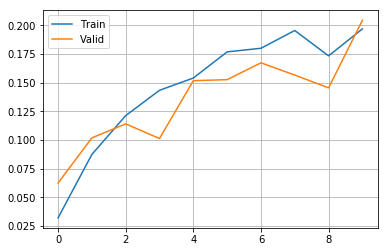

In [68]:
lenet = LeNet()
%time train_network(lenet, torch.device(DEVICE), a_epochs=10)

Epoch  0 0.0421
Epoch  1 0.1151
Epoch  2 0.1747
Epoch  3 0.2267
Epoch  4 0.2686
Epoch  5 0.3127
Epoch  6 0.3579
Epoch  7 0.3972
Epoch  8 0.4295
Epoch  9 0.4608
Epoch  10 0.485
Epoch  11 0.5082
Epoch  12 0.5308
Epoch  13 0.5511
Epoch  14 0.5666
Epoch  15 0.5816
Epoch  16 0.6012
Epoch  17 0.6143
Epoch  18 0.6268
Epoch  19 0.644
Epoch  20 0.6513
Epoch  21 0.6638
Epoch  22 0.6784
Epoch  23 0.688
Epoch  24 0.6978
Epoch  25 0.7073
Epoch  26 0.7151
Epoch  27 0.7263
Epoch  28 0.7354
Epoch  29 0.7431
Epoch  30 0.7527
Epoch  31 0.764
Epoch  32 0.7626
Epoch  33 0.7745
Epoch  34 0.784
Epoch  35 0.7898
Epoch  36 0.7936
Epoch  37 0.8021
Epoch  38 0.8096
Epoch  39 0.8167
Epoch  40 0.8169
Epoch  41 0.8184
Epoch  42 0.8303
Epoch  43 0.8354
Epoch  44 0.842
Epoch  45 0.843
Epoch  46 0.8488
Epoch  47 0.8495
Epoch  48 0.8539
Epoch  49 0.8573
Epoch  50 0.8633
Epoch  51 0.8674
Epoch  52 0.8681
Epoch  53 0.8652
Epoch  54 0.876
Epoch  55 0.8751
Epoch  56 0.8773
Epoch  57 0.881
Epoch  58 0.8797
Epoch  59 0.8843

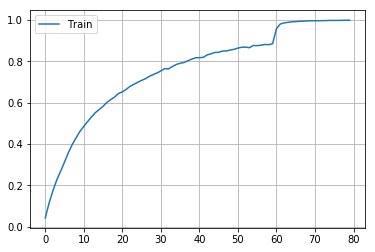

In [17]:
#без макспулинга в первой конволюции
resnet = CifarResNet()
%time train_network(resnet, torch.device(DEVICE))

Epoch  0 0.0445
Epoch  1 0.0866
Epoch  2 0.1246
Epoch  3 0.1627
Epoch  4 0.2015
Epoch  5 0.2332
Epoch  6 0.2589
Epoch  7 0.283
Epoch  8 0.3087
Epoch  9 0.3225
Epoch  10 0.3458
Epoch  11 0.3598
Epoch  12 0.3747
Epoch  13 0.3874
Epoch  14 0.4012
Epoch  15 0.4122
Epoch  16 0.4256
Epoch  17 0.4348
Epoch  18 0.4427
Epoch  19 0.4523
Epoch  20 0.4655
Epoch  21 0.4713
Epoch  22 0.4848
Epoch  23 0.4915
Epoch  24 0.5002
Epoch  25 0.5068
Epoch  26 0.5127
Epoch  27 0.5222
Epoch  28 0.5273
Epoch  29 0.5348
Epoch  30 0.5412
Epoch  31 0.5496
Epoch  32 0.5559
Epoch  33 0.5612
Epoch  34 0.5651
Epoch  35 0.5742
Epoch  36 0.578
Epoch  37 0.5836
Epoch  38 0.5898
Epoch  39 0.5947
Epoch  40 0.5981
Epoch  41 0.6082
Epoch  42 0.6116
Epoch  43 0.6188
Epoch  44 0.6254
Epoch  45 0.6227
Epoch  46 0.6312
Epoch  47 0.6314
Epoch  48 0.6438
Epoch  49 0.6454
Epoch  50 0.6525
Epoch  51 0.6552
Epoch  52 0.661
Epoch  53 0.6598
Epoch  54 0.6673
Epoch  55 0.6722
Epoch  56 0.6734
Epoch  57 0.6802
Epoch  58 0.6814
Epoch  59 

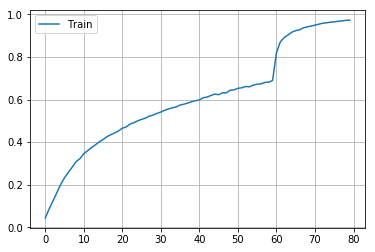

In [24]:
#с максс пулом
resnet = CifarResNet()
%time train_network(resnet, torch.device(DEVICE))

# Важно переключить сеть в режим eval - иначе dropout будет работать некорректно

In [20]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [18]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [25]:
# my_solution = make_solution(dense_net, DEVICE)
my_solution = make_solution(resnet, DEVICE)

In [26]:
with open('my_solution.csv', 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)